In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader
import pandas as pd



#---A) Hyper Parameters
cfg = dict()
cfg['numEpoch'] = 30 #epochs
cfg['learning_rate'] = .0001 #learning rate
cfg['batchSize'] = 20 # batchSize

#--B) Intialization
#B.1 - loader
MNIST_training_set= datasets.FashionMNIST(root='data_fashionMNIST', train=True, download=True, transform=transforms.ToTensor() )
MNIST_test_set = datasets.FashionMNIST(root='data_fashionMNIST', train=False, download=True, transform=transforms.ToTensor())
myLoader_train = DataLoader(MNIST_training_set,shuffle=True,batch_size=cfg['batchSize'])
myLoader_test = DataLoader(MNIST_test_set,shuffle=False,batch_size=cfg['batchSize']) # no point in shuffling test set

N_train = len(MNIST_training_set) # number of images in the training set
N_test = len(MNIST_test_set)

num_mini_batch_train = len(myLoader_train)
num_mini_batch_test = len(myLoader_test)

/var/folders/br/rzkf1nz907qd3q234g81vfm00000gn/T/ipykernel_70759/550292466.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## A) Linear Model

In [ ]:
def trainModel(optimizer,myMod,df,myLoss,cfg,Loader_test=myLoader_test, Loader_train = myLoader_train):
    num_mini_batch_train = len(Loader_train)
    num_mini_batch_test = len(Loader_test)
    for epoch in range(cfg['numEpoch']):
        print("--epoch",epoch)
        #--C.1) Train
        running_loss_train = 0.0
        accuracy_train = 0.0
        myMod.train()
        for I,y in Loader_train:
            I,y = I.to(device),y.to(device)
            #1) set gradient loss to zero
            optimizer.zero_grad()
            #2) get score and loss
            score = myMod(I)
            loss = myLoss(score,y)
            #3) estimate gradient and update paramters
            loss.backward()
            optimizer.step()
            #4) estimate loss and accuracy over the training set
            running_loss_train+= loss.detach().numpy()
            accuracy_train+=(score.argmax(dim=1)==y).sum().numpy()
        #--C.2) Test
        running_test_loss = 0.0
        accuracy_test = 0.0
        myMod.eval()
        with torch.no_grad():
            for I,y in Loader_test:
                score = myMod(I)
                loss = myLoss(score,y)
                #estimate loss and accuracy
                running_test_loss+=loss.detach().numpy()
                accuracy_test+=(score.argmax(dim=1)==y).sum().numpy()
        #end of epoch
        loss_train = running_loss_train/num_mini_batch_train
        loss_test = running_test_loss/num_mini_batch_test
        accuracy_train /= N_train
        accuracy_test /= N_test
        print('    loss     (train, test): {:.4f},  {:.4f}'.format(loss_train, loss_test))
        print('    accuracy (train, test): {:.4f},  {:.4f}'.format(accuracy_train, accuracy_test))
        df.loc[epoch] = [epoch, loss_train, loss_test, accuracy_train, accuracy_test]

In [ ]:
# Define the linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.pool1 = nn.MaxPool2d(4)
        self.fc = nn.Linear(49, 10)

    def forward(self, x):
        x1 = self.pool1(x)
        x2 = x1.view(x1.size(0), -1)  # Flatten the input
        x3 = self.fc(x2)
        return x3

In [ ]:
myMod_Linear = LinearClassifier().to(device)
sum(p.numel() for p in myMod_Linear.parameters() if p.requires_grad)

500

Linear Model Parameters = 500


In [ ]:
#B.2 optimizer
optimizer_Linear = torch.optim.Adam(myMod_Linear.parameters(),lr=cfg['learning_rate'])

#B.3 Loss
myLoss_Linear = nn.CrossEntropyLoss()

#B.4
df_Linear = pd.DataFrame(index=range(cfg['numEpoch']),columns=('epoch', 'loss_train', 'loss_test','accuracy_train','accuracy_test'))

trainModel(optimizer_Linear,myMod_Linear,df_Linear,myLoss_Linear,cfg,Loader_test=myLoader_test, Loader_train = myLoader_train)


--epoch 0
    loss     (train, test): 1.8120,  1.4526
    accuracy (train, test): 0.4615,  0.5662
--epoch 1
    loss     (train, test): 1.2869,  1.1763
    accuracy (train, test): 0.5874,  0.5940
--epoch 2
    loss     (train, test): 1.1001,  1.0559
    accuracy (train, test): 0.6102,  0.6138
--epoch 3
    loss     (train, test): 1.0071,  0.9879
    accuracy (train, test): 0.6313,  0.6344
--epoch 4
    loss     (train, test): 0.9507,  0.9440
    accuracy (train, test): 0.6517,  0.6488
--epoch 5
    loss     (train, test): 0.9123,  0.9127
    accuracy (train, test): 0.6673,  0.6644
--epoch 6
    loss     (train, test): 0.8839,  0.8893
    accuracy (train, test): 0.6774,  0.6764
--epoch 7
    loss     (train, test): 0.8620,  0.8706
    accuracy (train, test): 0.6865,  0.6812
--epoch 8
    loss     (train, test): 0.8445,  0.8552
    accuracy (train, test): 0.6926,  0.6872
--epoch 9
    loss     (train, test): 0.8299,  0.8433
    accuracy (train, test): 0.6979,  0.6910
--epoch 10
    loss 

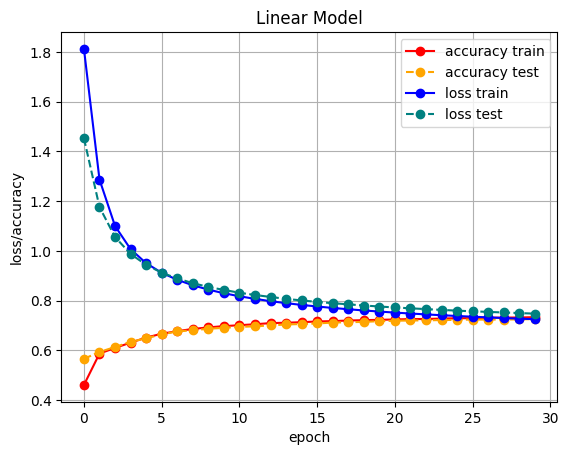

In [ ]:
from matplotlib import pyplot as plt
plt.figure(1)
plt.clf()
plt.title('Linear Model')
plt.plot(df_Linear['epoch'],df_Linear['accuracy_train'],marker='o',color='red')
plt.plot(df_Linear['epoch'],df_Linear['accuracy_test'],marker='o',color='orange',linestyle='dashed')
plt.plot(df_Linear['epoch'],df_Linear['loss_train'],marker='o',color='blue')
plt.plot(df_Linear['epoch'],df_Linear['loss_test'],marker='o',color='teal',linestyle='dashed')
plt.grid()
plt.xlabel(r'epoch')
plt.ylabel(r'loss/accuracy')
plt.legend(['accuracy train','accuracy test','loss train','loss test'])
plt.show()

## B) Multi-Layer Perceptron (MLP)

In [ ]:
#define MLP classifier
class MlpClassifier(nn.Module):
    def __init__(self):
        super(MlpClassifier, self).__init__()
        self.pool1 = nn.MaxPool2d(5)
        self.fc1 = nn.Linear(25,13 )
        self.fc2 = nn.Linear(13,10 )

    def forward(self, x):
        x1 = self.pool1(x)
        x2 = x1.view(x1.size(0), -1)  # Flatten the input
        x3 = F.relu(self.fc1(x2))
        x4 = self.fc2(x3)
        return x4

In [ ]:
myMod_MLP = MlpClassifier().to(device)
sum(p.numel() for p in myMod_MLP.parameters() if p.requires_grad)

478

MLP Classifier Parameters = 478

In [ ]:
#B.2 optimizer
optimizer_MLP = torch.optim.Adam(myMod_MLP.parameters(),lr=cfg['learning_rate'])

#B.3 Loss
myLoss_MLP = nn.CrossEntropyLoss()

#B.4
df_MLP = pd.DataFrame(index=range(cfg['numEpoch']),columns=('epoch', 'loss_train', 'loss_test','accuracy_train','accuracy_test'))

trainModel(optimizer_MLP,myMod_MLP,df_MLP,myLoss_MLP,cfg,Loader_test=myLoader_test, Loader_train = myLoader_train)

--epoch 0
    loss     (train, test): 2.0452,  1.7093
    accuracy (train, test): 0.2884,  0.4782
--epoch 1
    loss     (train, test): 1.4750,  1.3154
    accuracy (train, test): 0.5354,  0.5772
--epoch 2
    loss     (train, test): 1.2125,  1.1412
    accuracy (train, test): 0.5864,  0.5897
--epoch 3
    loss     (train, test): 1.0825,  1.0510
    accuracy (train, test): 0.5941,  0.5984
--epoch 4
    loss     (train, test): 1.0133,  0.9984
    accuracy (train, test): 0.6047,  0.6085
--epoch 5
    loss     (train, test): 0.9696,  0.9624
    accuracy (train, test): 0.6163,  0.6227
--epoch 6
    loss     (train, test): 0.9383,  0.9361
    accuracy (train, test): 0.6322,  0.6412
--epoch 7
    loss     (train, test): 0.9145,  0.9152
    accuracy (train, test): 0.6473,  0.6491
--epoch 8
    loss     (train, test): 0.8962,  0.8990
    accuracy (train, test): 0.6558,  0.6573
--epoch 9
    loss     (train, test): 0.8817,  0.8854
    accuracy (train, test): 0.6605,  0.6641
--epoch 10
    loss 

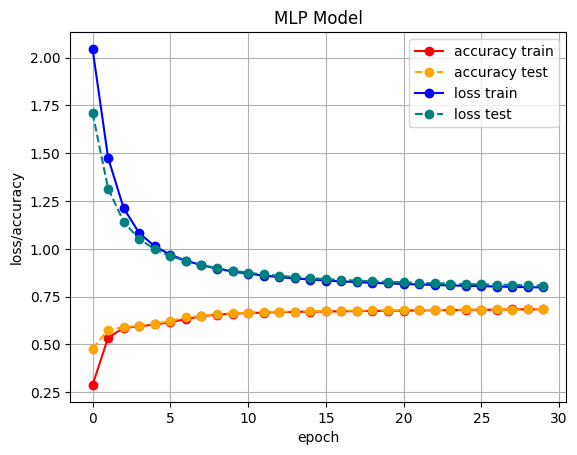

In [ ]:
from matplotlib import pyplot as plt
plt.figure(2)
plt.clf()
plt.title('MLP Model')
plt.plot(df_MLP['epoch'],df_MLP['accuracy_train'],marker='o',color='red')
plt.plot(df_MLP['epoch'],df_MLP['accuracy_test'],marker='o',color='orange',linestyle='dashed')
plt.plot(df_MLP['epoch'],df_MLP['loss_train'],marker='o',color='blue')
plt.plot(df_MLP['epoch'],df_MLP['loss_test'],marker='o',color='teal',linestyle='dashed')
plt.grid()
plt.xlabel(r'epoch')
plt.ylabel(r'loss/accuracy')
plt.legend(['accuracy train','accuracy test','loss train','loss test'])
plt.show()

## C) CNN Classifier

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN,self).__init__()  # call the constructor of the parent class
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3,3,3)
        self.conv3 = nn.Conv2d(3, 5, 3)

        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)

        self.bn1 = nn.BatchNorm2d(3)
        self.bn2 = nn.BatchNorm2d(3)
        self.bn3 = nn.BatchNorm2d(5)

        self.fc = nn.Linear(5 * 2 * 2, 10)
        #self.bnL = nn.BatchNorm1d(10)

        #self.dropout = nn.Dropout(p=0.3)


    def forward(self, x):


        x1 = self.pool1(self.bn1(F.relu(self.conv1(x))))
        x2 = self.pool2(self.bn2(F.relu( F.pad(self.conv2(x1),(0,1,0,1)))))
        x3 = self.pool3(self.bn3(F.relu(self.conv3(x2))))
       # x4 = self.dropout(x3)
        score = self.fc(x3.view(-1, 5 * 2 * 2))
        return score

In [ ]:
myMod_CNN = MyCNN().to(device)
sum(p.numel() for p in myMod_CNN.parameters() if p.requires_grad)

486

CNN Model Parameters = 486

In [ ]:
#B.2 optimizer
optimizer_CNN = torch.optim.Adam(myMod_CNN.parameters(),lr=cfg['learning_rate'])

#B.3 Loss
myLoss_CNN = nn.CrossEntropyLoss()

#B.4
df_CNN = pd.DataFrame(index=range(cfg['numEpoch']),columns=('epoch', 'loss_train', 'loss_test','accuracy_train','accuracy_test'))

trainModel(optimizer_CNN,myMod_CNN,df_CNN,myLoss_CNN,cfg,Loader_test=myLoader_test, Loader_train = myLoader_train)

--epoch 0
    loss     (train, test): 1.5430,  1.0651
    accuracy (train, test): 0.5072,  0.6688
--epoch 1
    loss     (train, test): 0.9017,  0.8022
    accuracy (train, test): 0.6972,  0.7168
--epoch 2
    loss     (train, test): 0.7578,  0.7279
    accuracy (train, test): 0.7277,  0.7340
--epoch 3
    loss     (train, test): 0.7027,  0.6840
    accuracy (train, test): 0.7421,  0.7483
--epoch 4
    loss     (train, test): 0.6692,  0.6545
    accuracy (train, test): 0.7536,  0.7594
--epoch 5
    loss     (train, test): 0.6457,  0.6347
    accuracy (train, test): 0.7619,  0.7674
--epoch 6
    loss     (train, test): 0.6281,  0.6180
    accuracy (train, test): 0.7700,  0.7753
--epoch 7
    loss     (train, test): 0.6144,  0.6076
    accuracy (train, test): 0.7753,  0.7765
--epoch 8
    loss     (train, test): 0.6031,  0.5955
    accuracy (train, test): 0.7797,  0.7797
--epoch 9
    loss     (train, test): 0.5941,  0.5860
    accuracy (train, test): 0.7827,  0.7829
--epoch 10
    loss 

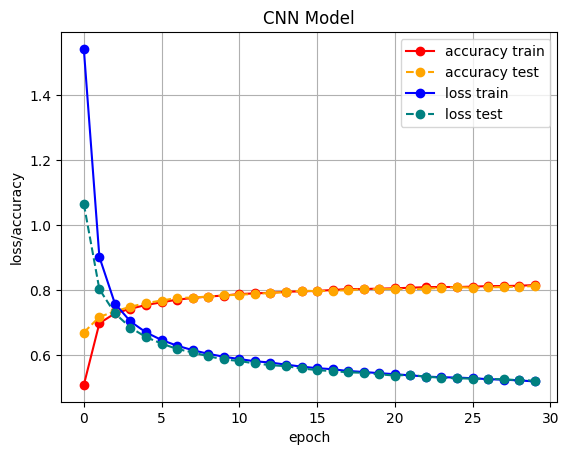

In [ ]:
from matplotlib import pyplot as plt
plt.figure(3)
plt.clf()
plt.title('CNN Model')
plt.plot(df_CNN['epoch'],df_CNN['accuracy_train'],marker='o',color='red')
plt.plot(df_CNN['epoch'],df_CNN['accuracy_test'],marker='o',color='orange',linestyle='dashed')
plt.plot(df_CNN['epoch'],df_CNN['loss_train'],marker='o',color='blue')
plt.plot(df_CNN['epoch'],df_CNN['loss_test'],marker='o',color='teal',linestyle='dashed')
plt.grid()
plt.xlabel(r'epoch')
plt.ylabel(r'loss/accuracy')
plt.legend(['accuracy train','accuracy test','loss train','loss test'])
plt.show()

## Comparision of Accuracy for All 3 Models


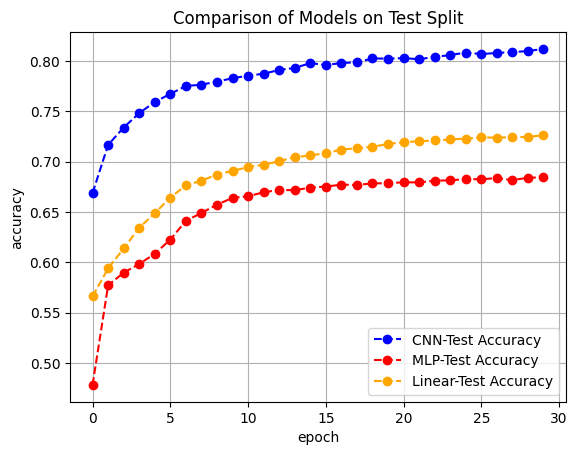

In [ ]:
from matplotlib import pyplot as plt
plt.figure(4)
plt.clf()
plt.title('Comparison of Models on Test Split')
plt.plot(df_CNN['epoch'],df_CNN['accuracy_test'],marker='o',color='blue',linestyle='dashed')
plt.plot(df_MLP['epoch'],df_MLP['accuracy_test'],marker='o',color='red',linestyle='dashed')
plt.plot(df_Linear['epoch'],df_Linear['accuracy_test'],marker='o',color='orange',linestyle='dashed')
plt.grid()
plt.xlabel(r'epoch')
plt.ylabel(r'accuracy')
plt.legend(['CNN-Test Accuracy','MLP-Test Accuracy','Linear-Test Accuracy'])
plt.show()